# Fractal Generative Models

This notebook samples from a pretrained fractal generative model.

[GitHub](https://github.com/LTH14/fractalgen)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the FractalGen GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
import os

!git clone https://github.com/LTH14/fractalgen.git

os.chdir('fractalgen')
os.environ['PYTHONPATH'] = '/env/python:/content/fractalgen'
!pip install timm==0.9.12
import torch
import numpy as np
from models import fractalgen
from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

Cloning into 'fractalgen'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 31 (delta 4), reused 3 (delta 3), pack-reused 15 (from 1)
Receiving objects: 100% (31/31), 78.70 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (4/4), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.21
    Uninstalling timm-1.0.21:
      Successfully uninstalled timm-1.0.21


# 2. Download Pre-trained Models on ImageNet 64x64

In [2]:
model_type = "fractalmar_in64" #@param ["fractalar_in64", "fractalmar_in64"]
if model_type == "fractalar_in64":
  download.download_pretrained_fractalar_in64(overwrite=False)
  num_conds=1
elif model_type == "fractalmar_in64":
  download.download_pretrained_fractalmar_in64(overwrite=False)
  num_conds=5
else:
  raise NotImplementedError
model = fractalgen.__dict__[model_type](
    guiding_pixel=False,
    num_conds=num_conds,
).to(device)
state_dict = torch.load("pretrained_models/{}/checkpoint-last.pth".format(model_type))["model"]
model.load_state_dict(state_dict)
model.eval() # important!

100%|█████████▉| 1649/1650 [00:23<00:00, 71.38MB/s]


FractalGen(
  (class_emb): Embedding(1000, 1024)
  (generator): MAR(
    (patch_emb): Linear(in_features=48, out_features=1024, bias=True)
    (patch_emb_ln): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (cond_emb): Linear(in_features=1024, out_features=1024, bias=True)
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.1, inplace=False)
          (norm)

# 3. Sample on ImageNet 64x64

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

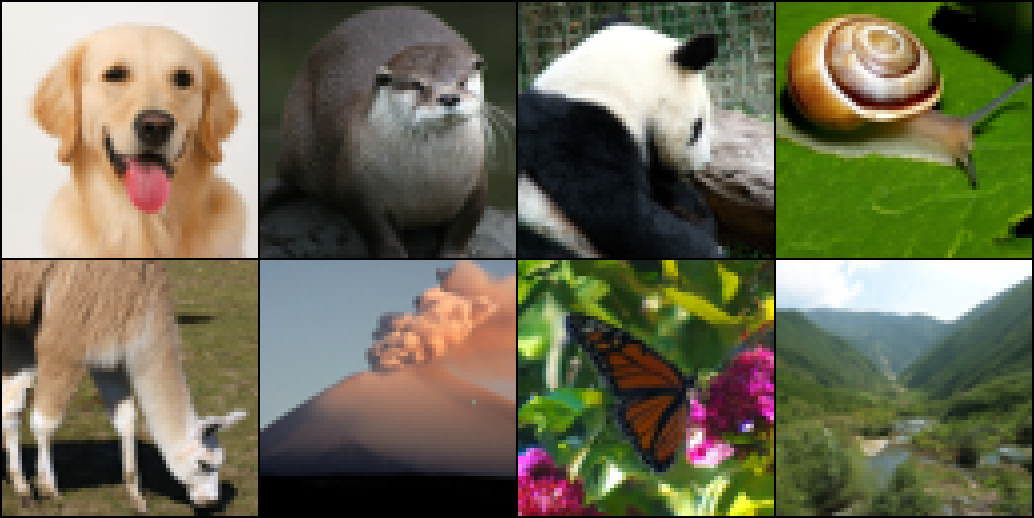

In [3]:
# Set user inputs
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
class_labels = 207, 360, 388, 113, 355, 980, 323, 979 #@param {type:"raw"}
num_iter_list = 64, 16 #@param {type:"raw"}
cfg_scale = 5 #@param {type:"slider", min:1, max:10, step:0.5}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.02 #@param {type:"slider", min:0.9, max:1.2, step:0.01}
filter_threshold = 1e-4
samples_per_row = 4 #@param {type:"number"}

label_gen = torch.Tensor(class_labels).long().cuda()
class_embedding = model.class_emb(label_gen)
if not cfg_scale == 1.0:
  class_embedding = torch.cat([class_embedding, model.fake_latent.repeat(label_gen.size(0), 1)], dim=0)

with torch.no_grad():
  with torch.cuda.amp.autocast():
    sampled_images = model.sample(
      cond_list=[class_embedding for _ in range(num_conds)],
      num_iter_list=num_iter_list,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      temperature=temperature,
      filter_threshold=filter_threshold,
      fractal_level=0,
      visualize=True)

# Denormalize images.
pix_mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().view(1, -1, 1, 1)
pix_std = torch.Tensor([0.229, 0.224, 0.225]).cuda().view(1, -1, 1, 1)
sampled_images = sampled_images * pix_std + pix_mean
sampled_images = torch.nn.functional.interpolate(sampled_images, scale_factor=4, mode="nearest")
sampled_images = sampled_images.detach().cpu()

# Save & display images
save_image(sampled_images, "samples.png", nrow=int(samples_per_row), normalize=True, value_range=(0, 1))
samples = Image.open("samples.png")

from IPython.display import display, clear_output
clear_output(wait=True)
display(samples)

# 4. Download Pre-trained Models on ImageNet 256x256

In [4]:
model_type = "fractalmar_huge_in256" #@param ["fractalmar_base_in256", "fractalmar_large_in256", "fractalmar_huge_in256"]
num_conds = 5
if model_type == "fractalmar_base_in256":
  download.download_pretrained_fractalmar_base_in256(overwrite=False)
elif model_type == "fractalmar_large_in256":
  download.download_pretrained_fractalmar_large_in256(overwrite=False)
elif model_type == "fractalmar_huge_in256":
  download.download_pretrained_fractalmar_huge_in256(overwrite=False)
else:
  raise NotImplementedError
model = fractalgen.__dict__[model_type](
    guiding_pixel=True,
    num_conds=num_conds
).to(device)
state_dict = torch.load("pretrained_models/{}/checkpoint-last.pth".format(model_type))["model"]
model.load_state_dict(state_dict)
model.eval() # important!

100%|█████████▉| 3242/3243 [00:52<00:00, 62.19MB/s]


FractalGen(
  (class_emb): Embedding(1000, 1280)
  (generator): MAR(
    (patch_emb): Linear(in_features=768, out_features=1280, bias=True)
    (patch_emb_ln): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
    (cond_emb): Linear(in_features=1280, out_features=1280, bias=True)
    (blocks): ModuleList(
      (0-39): 40 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.1, inplace=False)
          (norm

# 5. Sample on ImageNet 256x256

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

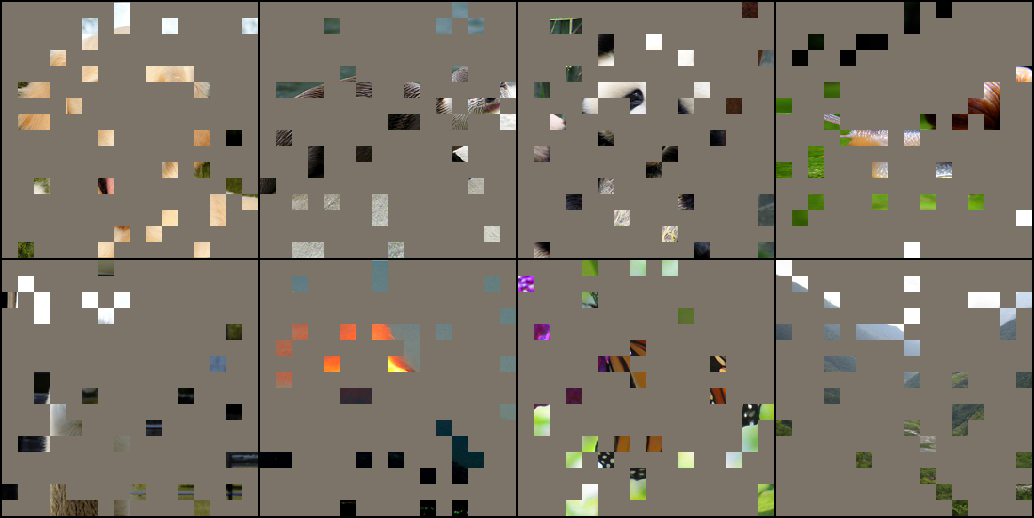

In [ ]:
# Set user inputs
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_iter_list = 64, 16, 16 #@param {type:"raw"}
cfg_scale = 10 #@param {type:"slider", min:1, max:20, step:0.5}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.1 #@param {type:"slider", min:0.9, max:1.2, step:0.01}
filter_threshold = 1e-3
class_labels = 207, 360, 388, 113, 355, 980, 323, 979 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

label_gen = torch.Tensor(class_labels).long().cuda()
class_embedding = model.class_emb(label_gen)
if not cfg_scale == 1.0:
  class_embedding = torch.cat([class_embedding, model.fake_latent.repeat(label_gen.size(0), 1)], dim=0)

with torch.no_grad():
  with torch.cuda.amp.autocast():
    sampled_images = model.sample(
      cond_list=[class_embedding for _ in range(num_conds)],
      num_iter_list=num_iter_list,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      temperature=temperature,
      filter_threshold=filter_threshold,
      fractal_level=0,
      visualize=True)

# Denormalize images.
pix_mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().view(1, -1, 1, 1)
pix_std = torch.Tensor([0.229, 0.224, 0.225]).cuda().view(1, -1, 1, 1)
sampled_images = sampled_images * pix_std + pix_mean
sampled_images = sampled_images.detach().cpu()

# Save & display images
save_image(sampled_images, "samples.png", nrow=int(samples_per_row), normalize=True, value_range=(0, 1))
samples = Image.open("samples.png")

from IPython.display import display, clear_output
clear_output(wait=True)
display(samples)